In [58]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv

--2021-10-16 23:14:17--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7077973 (6.8M) [text/plain]
Saving to: ‘AB_NYC_2019.csv.1’

AB_NYC_2019.csv.1   100%[===================>]   6.75M  --.-KB/s    in 0.09s   

2021-10-16 23:14:18 (79.1 MB/s) - ‘AB_NYC_2019.csv.1’ saved [7077973/7077973]



In [59]:
!ls

AB_NYC_2019.csv  AB_NYC_2019.csv.1  sample_data


In [60]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [61]:
columns = ['neighbourhood_group', 'room_type', 'latitude', 'longitude', 'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365', 'price']

df = pd.read_csv('AB_NYC_2019.csv', usecols=columns)
df.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Brooklyn,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [62]:
df.isna().sum()

neighbourhood_group                   0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [63]:
df.reviews_per_month = df.reviews_per_month.fillna(0)

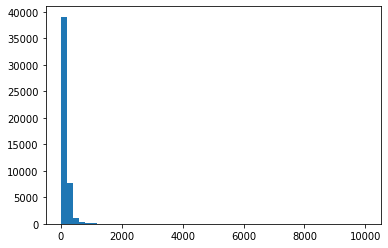

In [64]:
plt.hist(df.price, bins=50);

In [65]:
df.price = np.log1p(df.price)

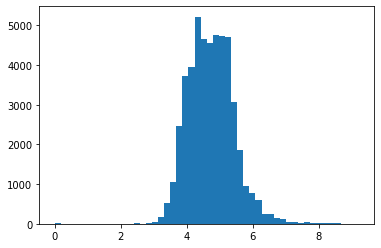

In [66]:
plt.hist(df.price, bins=50);

In [67]:
from sklearn.model_selection import train_test_split

df_train_val , df_test = train_test_split(df , random_state=1 , test_size = 0.2)
# 0.8*x = 0.2 ----> x = 0.2/0.8 = 0.25
df_train , df_val = train_test_split(df_train_val , random_state=1 , test_size = 0.25)
del df_train_val , df

In [68]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [69]:
y_train = df_train.price 
y_val = df_val.price 
y_test = df_test.price 

df_train.drop(columns=['price'], inplace=True)
df_val.drop(columns=['price'], inplace=True)
df_test.drop(columns=['price'], inplace=True)

In [70]:
train_dict = df_train.to_dict(orient="records")
val_dict = df_val.to_dict(orient="records")
test_dict = df_test.to_dict(orient="records")

In [71]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(train_dict)

X_val = dv.transform(val_dict)
X_test = dv.transform(test_dict)

In [72]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text


In [73]:
dtr = DecisionTreeRegressor(max_depth=1)
dtr.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=1,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [74]:
y_val_pred = dtr.predict(X_val)
rmse = np.sqrt(((np.expm1(y_val) - np.expm1(y_val_pred))**2).sum()/len(y_val))
rmse

210.6549597853951

In [75]:
print(dtr.feature_importances_)
print(dv.get_feature_names())
print(export_text(dtr, feature_names=dv.get_feature_names()))


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
['availability_365', 'calculated_host_listings_count', 'latitude', 'longitude', 'minimum_nights', 'neighbourhood_group=Bronx', 'neighbourhood_group=Brooklyn', 'neighbourhood_group=Manhattan', 'neighbourhood_group=Queens', 'neighbourhood_group=Staten Island', 'number_of_reviews', 'reviews_per_month', 'room_type=Entire home/apt', 'room_type=Private room', 'room_type=Shared room']
|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



In [77]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=10, random_state=1 , n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=-1, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [80]:
from sklearn import metrics
y_val_pred = rf.predict(X_val)
rmse = np.sqrt(((y_val - y_val_pred)**2).sum()/len(y_val))
print(rmse)
print(np.sqrt(metrics.mean_squared_error(y_val , y_val_pred)))

0.460888788095762
0.460888788095762


In [83]:
RMSEs = []

for i in range(10 , 201 , 10):
    rf = RandomForestRegressor(n_estimators=i, random_state=1 , n_jobs=-1)
    rf.fit(X_train, y_train)
    y_val_pred = rf.predict(X_val)
    rmse = np.sqrt(metrics.mean_squared_error(y_val , y_val_pred))
    RMSEs.append((i,rmse))

In [89]:
trees_n , scores = list(zip(*RMSEs))

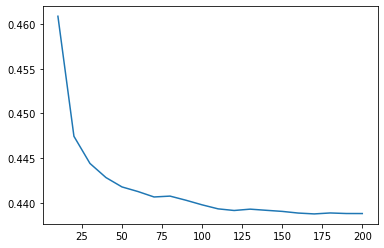

In [92]:
plt.plot(trees_n , scores)

In [95]:
RMSEs = []
for j in [10, 15, 20, 25]:
    for i in range(10 , 201 , 10):
        rf = RandomForestRegressor(n_estimators=i, random_state=1 , n_jobs=-1 , max_depth=j)
        rf.fit(X_train, y_train)
        y_val_pred = rf.predict(X_val)
        rmse = np.sqrt(metrics.mean_squared_error(y_val , y_val_pred))
        RMSEs.append((i, j , rmse))

In [97]:
columns = ['n_estimators', 'max_depth', 'RMSE']
df_scores = pd.DataFrame(RMSEs, columns=columns)
df_scores

,n_estimators,max_depth,RMSE
0,10,10,0.445210
1,20,10,0.441888
2,30,10,0.441207
3,40,10,0.441303
4,50,10,0.440947
...,...,...,...
75,160,25,0.438766
76,170,25,0.438641
77,180,25,0.438762
78,190,25,0.438670


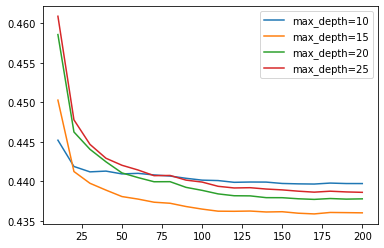

In [99]:
for j in [10, 15, 20, 25]:
    df_temp = df_scores[df_scores.max_depth==j]
    plt.plot(df_temp.n_estimators , df_temp.RMSE , label="max_depth=%d" %j)
plt.legend()

In [103]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20 , random_state=1 , n_jobs=-1)
rf.fit(X_train, y_train)
print(rf.feature_importances_)
print(dv.get_feature_names())


[7.65160846e-02 3.09063525e-02 1.52053975e-01 1.53219337e-01
 5.36452300e-02 2.83822549e-04 1.16611621e-03 3.40167443e-02
 1.15324234e-03 1.18026952e-04 4.35248857e-02 5.24379349e-02
 3.91896837e-01 4.52061759e-03 4.54079353e-03]
['availability_365', 'calculated_host_listings_count', 'latitude', 'longitude', 'minimum_nights', 'neighbourhood_group=Bronx', 'neighbourhood_group=Brooklyn', 'neighbourhood_group=Manhattan', 'neighbourhood_group=Queens', 'neighbourhood_group=Staten Island', 'number_of_reviews', 'reviews_per_month', 'room_type=Entire home/apt', 'room_type=Private room', 'room_type=Shared room']


In [111]:
list(zip(np.round(rf.feature_importances_,3),dv.get_feature_names()))

[(0.077, 'availability_365'),
 (0.031, 'calculated_host_listings_count'),
 (0.152, 'latitude'),
 (0.153, 'longitude'),
 (0.054, 'minimum_nights'),
 (0.0, 'neighbourhood_group=Bronx'),
 (0.001, 'neighbourhood_group=Brooklyn'),
 (0.034, 'neighbourhood_group=Manhattan'),
 (0.001, 'neighbourhood_group=Queens'),
 (0.0, 'neighbourhood_group=Staten Island'),
 (0.044, 'number_of_reviews'),
 (0.052, 'reviews_per_month'),
 (0.392, 'room_type=Entire home/apt'),
 (0.005, 'room_type=Private room'),
 (0.005, 'room_type=Shared room')]

In [141]:
import xgboost as xgb

features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val , feature_names=features)


In [142]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1
}

watchlist = [(dtrain, 'train'), (dval, 'val')]

model = xgb.train(xgb_params, dtrain, num_boost_round=100 , evals=watchlist , verbose_eval=5)


In [143]:
print(output)

[0]	train-rmse:3.02752	val-rmse:3.02415
[5]	train-rmse:0.674904	val-rmse:0.677523
[10]	train-rmse:0.439151	val-rmse:0.449813
[15]	train-rmse:0.423031	val-rmse:0.439126
[20]	train-rmse:0.417246	val-rmse:0.437226
[25]	train-rmse:0.412681	val-rmse:0.436174
[30]	train-rmse:0.407564	val-rmse:0.435124
[35]	train-rmse:0.404793	val-rmse:0.434324
[40]	train-rmse:0.401326	val-rmse:0.434602
[45]	train-rmse:0.399043	val-rmse:0.434132
[50]	train-rmse:0.395527	val-rmse:0.433357
[55]	train-rmse:0.391777	val-rmse:0.433642
[60]	train-rmse:0.388646	val-rmse:0.43327
[65]	train-rmse:0.383917	val-rmse:0.432713
[70]	train-rmse:0.380675	val-rmse:0.432784
[75]	train-rmse:0.377159	val-rmse:0.432945
[80]	train-rmse:0.374531	val-rmse:0.432804
[85]	train-rmse:0.37268	val-rmse:0.4331
[90]	train-rmse:0.370312	val-rmse:0.433563
[95]	train-rmse:0.366663	val-rmse:0.433719
[99]	train-rmse:0.36437	val-rmse:0.434066



In [144]:
results = []
for line in output.stdout.strip().split('\n'):
    it_line, train_line, val_line = line.split('\t')

    it = int(it_line.strip('[]'))
    train = float(train_line.split(':')[1])
    val = float(val_line.split(':')[1])

    results.append((it, train, val))
    
columns = ['num_iter', 'train_rmse', 'val_rmse']
df_results = pd.DataFrame(results, columns=columns)
df_results

,num_iter,train_rmse,val_rmse
0,0,3.027520,3.024150
1,5,0.674904,0.677523
2,10,0.439151,0.449813
3,15,0.423031,0.439126
4,20,0.417246,0.437226
5,25,0.412681,0.436174
6,30,0.407564,0.435124
7,35,0.404793,0.434324
8,40,0.401326,0.434602
9,45,0.399043,0.434132


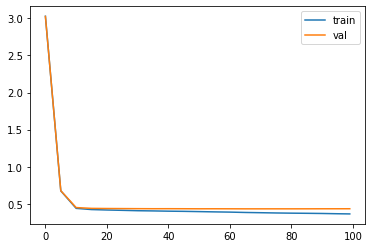

In [145]:
plt.plot(df_results.num_iter, df_results.train_rmse, label='train')
plt.plot(df_results.num_iter, df_results.val_rmse, label='val')
plt.legend()


In [149]:
dval = xgb.DMatrix(X_val, feature_names=features)

y_val_pred = model.predict(dval)
print(np.sqrt(((y_val - y_val_pred)**2).sum()/len(y_val)))


0.43406553396155145


In [157]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val , feature_names=features)


scores = {}

for i in [0.01,0.1,0.3]:
    xgb_params = {
    'eta': i,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1
    }
    model = xgb.train(xgb_params, dtrain, num_boost_round=100 )
    y_val_pred = model.predict(dval)
    scores[i] = np.sqrt(((y_val - y_val_pred)**2).sum()/len(y_val))


In [158]:
scores

{0.01: 1.6304937543510767, 0.1: 0.43287300538946744, 0.3: 0.43406553396155145}

In [170]:
%%capture output3

features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val , feature_names=features)

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1
}

watchlist = [(dtrain, 'train'), (dval, 'val')]

model = xgb.train(xgb_params, dtrain, num_boost_round=100 , evals=watchlist , verbose_eval=5)


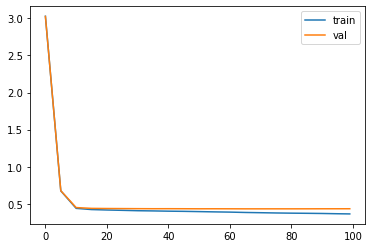

In [171]:
results = []
for line in output3.stdout.strip().split('\n'):
    it_line, train_line, val_line = line.split('\t')

    it = int(it_line.strip('[]'))
    train = float(train_line.split(':')[1])
    val = float(val_line.split(':')[1])

    results.append((it, train, val))
    
columns = ['num_iter', 'train_rmse', 'val_rmse']
df_results = pd.DataFrame(results, columns=columns)
plt.plot(df_results.num_iter, df_results.train_rmse, label='train')
plt.plot(df_results.num_iter, df_results.val_rmse, label='val')
plt.legend()